# Tuning Quadratisation penalty

In the current formulation, higher order terms only occur in the max-norm constraints. To test for appropriate $M_{kl}$, we consider the max-norm constraints:
\begin{align*}
    \sum_{n=0}^{2L}\left(|y_n\left(\mathbf{u}(\mathbf{q})\right)|^2 - \mu + k\right)^2
\end{align*}
for some random vector $\mathbf{u}$. Then, compare $z_{kl}$ with $q_k$ and $q_l$. Start at 'low' $M_{kl}$, anneal, If



| $q_k$ | $q_l$ | $z_{kl}$ |
| :-: | :-: | :-: |
| 0 | 0 | 0|
| 0 | 1 | 0|
| 1 | 0 | 0|
| 1 | 1 | 1|

then keep $M_{kl}$, else increase $M_{kl}$.

<br>

### Random vector

means giving random domains to Create_float_vec()

<br>

In [55]:
import numpy as np

In [56]:
# Let all the domains be around [-1,1]

root = np.array([-2,2], dtype='float')

ulen = 6

eps1 = np.around(np.random.uniform(-0.5, 0.5, ulen), decimals=2)
eps2 = np.around(np.random.uniform(-0.5, 0.5, ulen), decimals=2)

domains = np.tile(root, (ulen,1))

domains[:,0] = domains[:,0]+eps1
domains[:,1] = domains[:,1]+eps2
domains

array([[-1.87,  1.88],
       [-2.09,  2.35],
       [-1.82,  2.38],
       [-1.63,  2.3 ],
       [-1.9 ,  2.38],
       [-2.33,  1.54]])

In [57]:
from PyQubo_formulation import *
from Utilities import *
import pyqubo as pq


In [58]:
# create the vector

nq_u = 4
u = Create_float_vec(ulen, nq_u, domains)
u[0]

((1.875000 * (((Binary('q[0]') + (0.500000 * Binary('q[1]'))) + (0.250000 * Binary('q[2]'))) + (0.125000 * Binary('q[3]')))) + -1.870000)

In [59]:
# these are arbitrary for this purpose

muparams = np.array([4,[-3,3]], dtype='object')

In [60]:
# create the max norm problem

maxnorm = Max_Norm_LP(u, 1, muparams, muparams)

## Simulated Annealing

Now, we can test the quadtratisation success in simulated annealing 

In [66]:
import neal

sampler = neal.SimulatedAnnealingSampler()

sampler.parameters

{'beta_range': [],
 'num_reads': [],
 'num_sweeps': [],
 'beta_schedule_type': ['beta_schedule_options'],
 'seed': [],
 'interrupt_function': [],
 'initial_states': [],
 'initial_states_generator': []}

In [91]:
M = 1
model = maxnorm.compile(strength=M)

model_vars = model.variables

model_qubo = model.to_qubo()


({('kq[2]', 'q[16] * q[20]'): 0.0010700913780010701,
  ('q[0]', 'q[3]'): 1.0,
  ('kq[1]', 'q[6]'): -6.036666968821501,
  ('q[17] * q[21]', 'q[7]'): -0.02873244292262328,
  ('q[21]', 'q[3] * q[5]'): -0.027062537507435643,
  ('q[11] * q[14]', 'q[5] * q[19]'): 0.07659200627920208,
  ('q[15] * q[16]', 'q[9] * q[11]'): -0.28980759132671063,
  ('muq[0]', 'q[4] * q[10]'): -0.0012047540399997558,
  ('q[0] * q[11]', 'q[18]'): -0.3673951198661954,
  ('q[6] * q[17]', 'q[8] * q[14]'): 1.2254721004672333,
  ('kq[0]', 'q[9]'): -16.320673957140006,
  ('q[8]', 'q[8] * q[18]'): -2.0,
  ('q[0] * q[7]', 'q[17] * q[21]'): 1.0774666095983716,
  ('muq[2]', 'q[5] * q[10]'): -0.00015059425499996948,
  ('q[10] * q[11]', 'q[1] * q[4]'): 0.5738422032356859,
  ('q[16]', 'q[1] * q[6]'): -3.340981735188749,
  ('muq[3]', 'q[22] * q[23]'): -0.1755256653535078,
  ('q[7]', 'q[9] * q[12]'): -3.361458518571336,
  ('q[17] * q[18]', 'q[2] * q[3]'): 0.25160828101435534,
  ('muq[2]', 'q[4] * q[10]'): -0.00030118850999993896,

In [180]:
sampleset = sampler.sample_qubo(model_qubo[0], num_reads=1000)

In [109]:
unique_vars = model_vars[:nq_u*ulen+2*4]
print(unique_vars, '\n')
print(sampleset.variables[:10])

['muq[0]', 'muq[1]', 'muq[2]', 'muq[3]', 'q[0]', 'q[1]', 'q[2]', 'q[3]', 'q[4]', 'q[5]', 'q[6]', 'q[7]', 'q[8]', 'q[9]', 'q[10]', 'q[11]', 'q[12]', 'q[13]', 'q[14]', 'q[15]', 'q[16]', 'q[17]', 'q[18]', 'q[19]', 'q[20]', 'q[21]', 'q[22]', 'q[23]', 'kq[0]', 'kq[1]', 'kq[2]', 'kq[3]'] 

Variables(['kq[0]', 'kq[1]', 'kq[2]', 'kq[3]', 'muq[0]', 'muq[1]', 'muq[2]', 'muq[3]', 'q[0]', 'q[0] * q[10]'])


In [181]:
samples = sampleset.samples()
energies = sampleset.record['energy']

In [182]:
samples[0][unique_vars[5]+' * '+unique_vars[6]]

1

In [230]:
import itertools

# We know that in this formulation, only these get quadratised
quad_vars = unique_vars[4:28]


def quad_error(sample, variables):
    """
    Given a result sample and list of variables,
    check if quadratisation was respected. Checks if
    qk*ql == zkl.
    """
    
    combinations = list(itertools.combinations(variables, 2))

    res = []
    for pair in combinations:
        res.append(sample[pair[0]]*sample[pair[1]] == sample[pair[0]+' * '+pair[1]])

    res = np.array(res)
    res = res.astype(int)
    
    error = np.count_nonzero(res==0) / len(res)
    
    return error

quad_error(samples[0], quad_vars)

0.5036231884057971

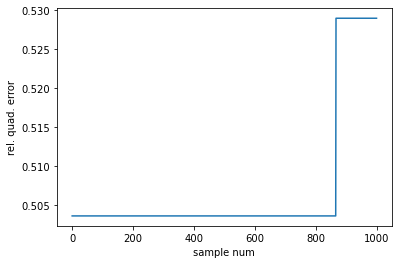

In [231]:
errors = np.zeros(len(samples))

for i in range(len(samples)):
    errors[i] = quad_error(samples[i], quad_vars)

plt.plot(errors)
plt.xlabel('sample num')
plt.ylabel('rel. quad. error')
plt.show()

In [232]:
# Varying M

M = np.linspace(1, 20, 40)

model_qubo = np.zeros(len(M), dtype='object')

for i in  range(len(M)):
    model = maxnorm.compile(strength=M[i])

    model_qubo[i] = model.to_qubo()

In [245]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors

cNorm = colors.Normalize(vmin=1, vmax=M[-1])
cm = plt.get_cmap('hot_r')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

median = np.zeros(len(M))
mean = np.zeros(len(M))

energies = []
samples = []

for i in range(len(M)):
    sampleset = sampler.sample_qubo(model_qubo[i][0], num_reads=1000)

    samples = sampleset.samples()
    energies = sampleset.record['energy']

    errors = np.zeros(len(samples))
    for j in range(len(samples)):
        errors[j] = quad_error(samples[j], quad_vars)
    
    plt.plot(errors, color=scalarMap.to_rgba(M[i]))
    
    median[i] = np.median(errors)
    mean[i] = np.mean(errors)
    
plt.xlabel('sample num')
plt.ylabel('quad. error')
plt.title('Quadratisation Errors For Varying Penalty Strengths')
plt.savefig('trial_quad_err.png', dpi=300)
plt.tight_layout()
plt.show()


KeyError: 0

ValueError: x and y must have same first dimension, but have shapes (4,) and (10,)

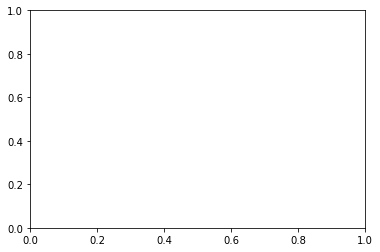

In [244]:
plt.plot(M, median, c='k', label='median')
plt.plot(M, mean, label='mean')
plt.xlabel('Quadratisation Penalty ')
plt.ylabel('quadratisation error')
plt.title('Quadratisation Errors For Varying Penalty Strengths')
plt.legend()
plt.tight_layout()
plt.savefig('quad_errs_medians_vs_M.png', dpi=300)
plt.show()

<br>

### Effect of Domain Magnitudes

So far, the random vector $\mathbf{u}$ was always modelled to be within the domain $[-2,2]$.

Larger domains introduce larger floats and thus biases and couplings between variables might be harder to overcome.

<br>

Test with a few differently sized domains:

<br>

In [242]:
root = np.linspace(0.5, 5, 10)

roots = np.array([[-root[i],root[i]] for i in range(len(root))])

print(roots)

[[-0.5  0.5]
 [-1.   1. ]
 [-1.5  1.5]
 [-2.   2. ]
 [-2.5  2.5]
 [-3.   3. ]
 [-3.5  3.5]
 [-4.   4. ]
 [-4.5  4.5]
 [-5.   5. ]]


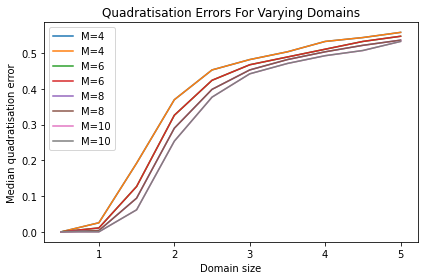

In [243]:
nq_u = 4
ulen = 6

eps1 = np.around(np.random.uniform(-0.5, 0.5, ulen), decimals=2)
eps2 = np.around(np.random.uniform(-0.5, 0.5, ulen), decimals=2)

M = [4,6,8,10]
for m in M:
    median = np.zeros(len(roots))
    mean = np.zeros(len(roots))
    for i in range(len(roots)):

        domains = np.tile(roots[i], (ulen,1))

        domains[:,0] = domains[:,0]+eps1
        domains[:,1] = domains[:,1]+eps2

        u2 = Create_float_vec(ulen, nq_u, domains)

        maxnorm = Max_Norm_LP(u2, 1, muparams, muparams)

        model = maxnorm.compile(strength=m)

        model_vars = model.variables

        model_qubo = model.to_qubo()

        sampleset = sampler.sample_qubo(model_qubo[0], num_reads=1000)

        samples = sampleset.samples()
        energies = sampleset.record['energy']

        errors = np.zeros(len(samples))
        for j in range(len(samples)):
            errors[j] = quad_error(samples[j], quad_vars)

        median[i] = np.median(errors)
        mean[i] = np.mean(errors)
    
    plt.plot(np.abs(roots), median, label='M={}'.format(m))
# plt.plot(mean, label='mean')
plt.xlabel('Domain size')
plt.ylabel('Median quadratisation error')
plt.title('Quadratisation Errors For Varying Domains')
plt.legend()
plt.tight_layout()
plt.savefig('quad_errs_median_vs_domain_varM.png', dpi=300)
plt.show()

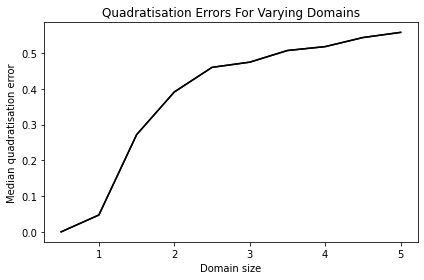